### Import libraries

In [1]:
import sys
sys.path.append("..")

In [2]:
from model import classic_model_mh, classic_model, losses, dot_prod_attention
from data import data_generation, batch_creator, gp_kernels, gp_priors
from keras.callbacks import ModelCheckpoint
from helpers import helpers, masks, metrics
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from inference import infer
import tensorflow as tf
import numpy as np
import matplotlib 
import time
import keras
plt.style.use('ggplot')

/Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.


In [3]:
save_dir = '/Users/omernivron/Downloads/GPT'

In [4]:
pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te, _, df_te = data_generation.data_generator_for_gp_mimick_gpt(150, ordered = False)

m = np.mean(pad_pos_tr)
std = np.std(pad_pos_tr)
m_y = np.mean(pad_y_fren_tr)
std_y = np.std(pad_y_fren_tr)

pad_pos_tr = (pad_pos_tr - m) / std
pad_pos_te = (pad_pos_te - m) / std
pad_y_fren_tr = (pad_y_fren_tr - m_y) / std_y
pad_y_fren_te = (pad_y_fren_te - m_y) / std_y

In [5]:
loss_object = tf.keras.losses.MeanSquaredError()
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')
m_tr = tf.keras.metrics.Mean()
m_te = tf.keras.metrics.Mean()

In [11]:
@tf.function
def train_step(decoder, optimizer_c, train_loss, m_tr, pos, curr_pos, tar):
    '''
    A typical train step function for TF2. Elements which we wish to track their gradient
    has to be inside the GradientTape() clause. see (1) https://www.tensorflow.org/guide/migrate 
    (2) https://www.tensorflow.org/tutorials/quickstart/advanced
    ------------------
    Parameters:
    pos (np array): array of positions (x values) - the 1st/2nd output from data_generator_for_gp_mimick_gpt
    tar (np array): array of targets. Notice that if dealing with sequnces, we typically want to have the targets go from 0 to n-1. The 3rd/4th output from data_generator_for_gp_mimick_gpt  
    pos_mask (np array): see description in position_mask function
    ------------------    
    '''
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    combined_mask_pos = masks.create_masks(pos)
    combined_mask_tar = masks.create_masks(tar_inp)


    with tf.GradientTape(persistent=True) as tape:
#         pred, pred_log_sig = decoder(pos, tar_inp, True, pos_mask, combined_mask_tar)
        # starting from 9 means we want to have the first 10 traget r.v y as static 
        # and they are not going to be part of the loss calculation
        pred = decoder(pos, curr_pos, tar_inp, True, combined_mask_pos , combined_mask_tar)


# 
#         loss, mse, mask = losses.loss_function(tar_real, pred, pred_log_sig)
        loss, mse, mask = losses.loss_function(tar_real[:, 50:], pred = pred[:, 50:, 0], pred_log_sig = pred[:, 50:, 1])



    gradients = tape.gradient(loss, decoder.trainable_variables)
    # Ask the optimizer to apply the processed gradients.
    optimizer_c.apply_gradients(zip(gradients, decoder.trainable_variables))
    train_loss(loss)
    m_tr.update_state(mse, mask)
    return pred[:, :, 0], pred[:, :, 1]

In [12]:
@tf.function
def test_step(decoder, test_loss, m_te, pos_te, curr_pos_te, tar_te):
    '''
    
    ---------------
    Parameters:
    pos (np array): array of positions (x values) - the 1st/2nd output from data_generator_for_gp_mimick_gpt
    tar (np array): array of targets. Notice that if dealing with sequnces, we typically want to have the targets go from 0 to n-1. The 3rd/4th output from data_generator_for_gp_mimick_gpt  
    pos_mask_te (np array): see description in position_mask function
    ---------------
    
    '''
    tar_inp_te = tar_te[:, :-1]
    tar_real_te = tar_te[:, 1:]
    combined_mask_pos_te = masks.create_masks(pos_te)
    combined_mask_tar_te = masks.create_masks(tar_inp_te)    
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
#   pred = decoder(pos_te, tar_inp_te, False, pos_mask_te, combined_mask_tar_te)


#     pred, pred_log_sig = decoder(pos_te, tar_inp_te, False, pos_mask_te, combined_mask_tar_te)
    pred_te = decoder(pos_te, curr_pos_te, tar_inp_te, False, combined_mask_pos_te, combined_mask_tar_te)


#     t_loss, t_mse, t_mask = losses.loss_function(tar_real_te, pred, pred_log_sig)
    t_loss, t_mse, t_mask = losses.loss_function(tar_real_te[:, 50:], pred = pred_te[:, 50:, 0], pred_log_sig = pred_te[:, 50:, 1])

    test_loss(t_loss)
    m_te.update_state(t_mse, t_mask)
    return pred_te[:, :, 0], pred_te[:, :, 1]

In [13]:
tf.keras.backend.set_floatx('float64')

In [ ]:
batch_pos_tr, batch_tar_tr, _ = batch_creator.fake_batch(pad_pos_tr, pad_y_fren_tr, batch_s=1)
batch_pos_tr1 = batch_pos_tr[:, :-1]
batch_pos_tr_current = batch_pos_tr[:, 1:]

In [9]:
                batch_pos_tr, batch_tar_tr, _ = batch_creator.create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr, batch_s=2)
                batch_pos_tr1 = batch_pos_tr[:, :-1]
                batch_pos_tr_current = batch_pos_tr[:, 1:]

Already exists
Restored from /Users/omernivron/Downloads/GPT/ckpt/check_1/ckpt-124
Tensor("truediv_1:0", shape=(), dtype=float64)
Tensor("truediv_1:0", shape=(), dtype=float64)


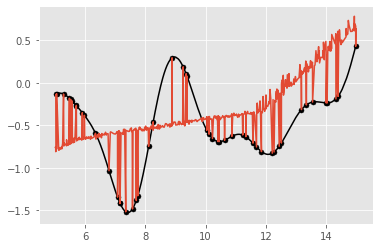

Tensor("truediv_1:0", shape=(), dtype=float64)
Epoch 0 batch 0 train Loss 0.1445 test Loss 0.7816 with MSE metric 1.0573


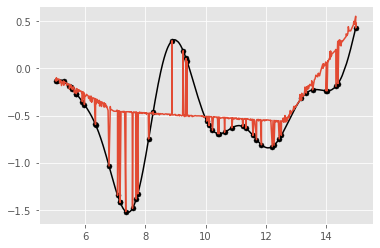

Epoch 1 batch 0 train Loss -0.0071 test Loss 1.0254 with MSE metric 0.9400


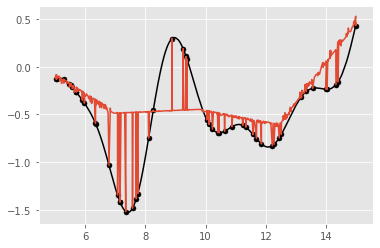

Epoch 2 batch 0 train Loss -0.0300 test Loss 1.4272 with MSE metric 1.1300


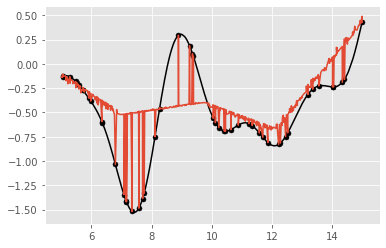

Epoch 3 batch 0 train Loss -0.0491 test Loss 1.4026 with MSE metric 1.0094


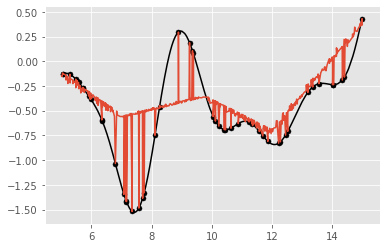

Epoch 4 batch 0 train Loss -0.0726 test Loss 1.5750 with MSE metric 1.0414


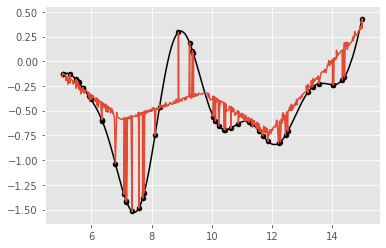

Epoch 5 batch 0 train Loss -0.0898 test Loss 1.5460 with MSE metric 0.9565


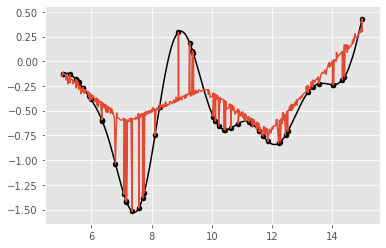

Epoch 6 batch 0 train Loss -0.1005 test Loss 1.8870 with MSE metric 1.0891


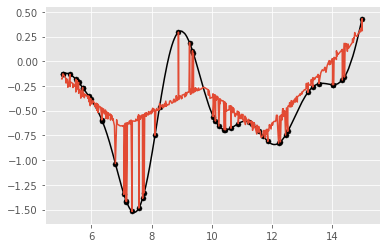

Epoch 7 batch 0 train Loss -0.1167 test Loss 2.1371 with MSE metric 1.1162


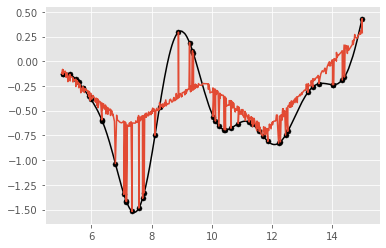

Epoch 8 batch 0 train Loss -0.1177 test Loss 2.0876 with MSE metric 1.1130


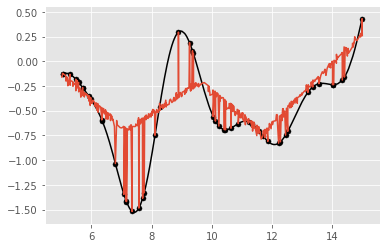

Epoch 9 batch 0 train Loss -0.1404 test Loss 2.1902 with MSE metric 1.0610


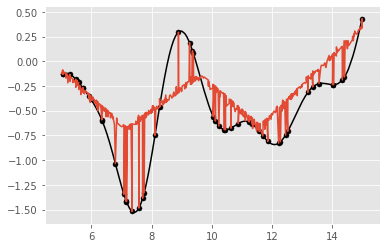

Epoch 10 batch 0 train Loss -0.1131 test Loss 2.8697 with MSE metric 1.3893


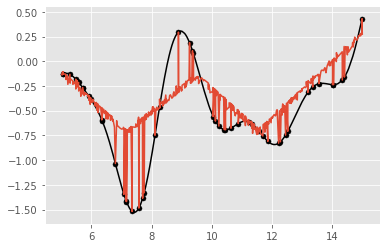

Epoch 11 batch 0 train Loss -0.1452 test Loss 3.0507 with MSE metric 1.3589


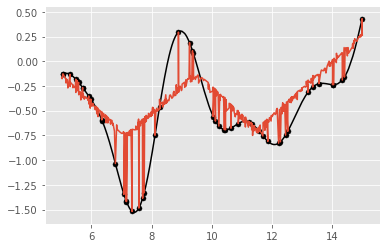

Epoch 12 batch 0 train Loss -0.1606 test Loss 2.6414 with MSE metric 1.1277


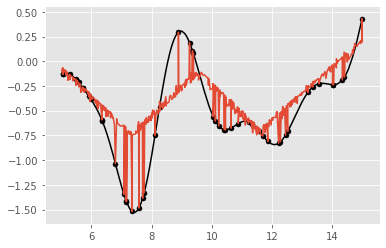

Epoch 13 batch 0 train Loss -0.1658 test Loss 2.7388 with MSE metric 1.2083


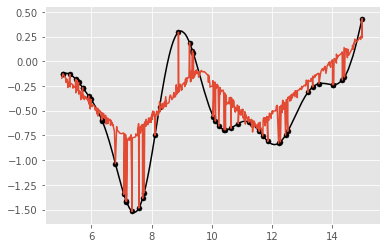

Epoch 14 batch 0 train Loss -0.1764 test Loss 2.9698 with MSE metric 1.2234


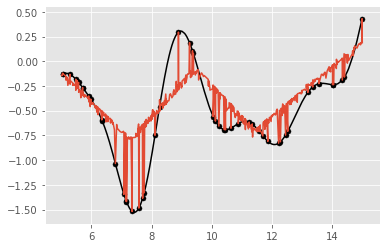

Epoch 15 batch 0 train Loss -0.1956 test Loss 3.7333 with MSE metric 1.3594


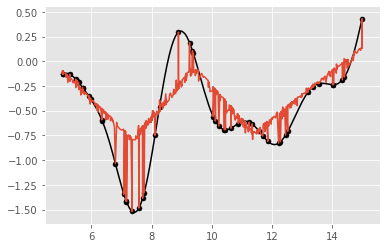

Epoch 16 batch 0 train Loss -0.2052 test Loss 3.9463 with MSE metric 1.4030


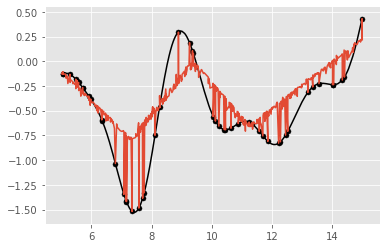

Epoch 17 batch 0 train Loss -0.1788 test Loss 3.9290 with MSE metric 1.4505


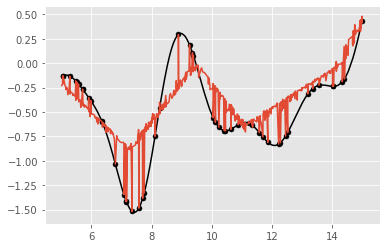

Epoch 18 batch 0 train Loss -0.2216 test Loss 3.8809 with MSE metric 1.2802


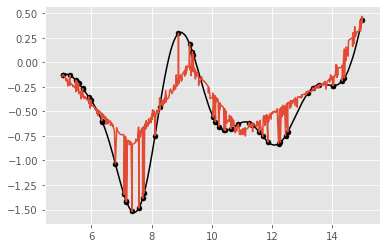

Epoch 19 batch 0 train Loss -0.2391 test Loss 4.8091 with MSE metric 1.4478


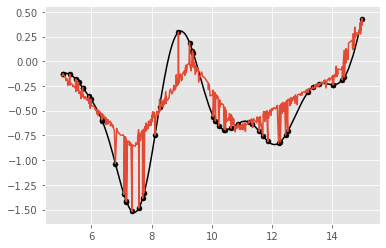

Epoch 20 batch 0 train Loss -0.2521 test Loss 4.7424 with MSE metric 1.3839


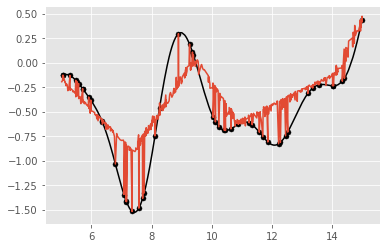

Epoch 21 batch 0 train Loss -0.2504 test Loss 4.7468 with MSE metric 1.4163


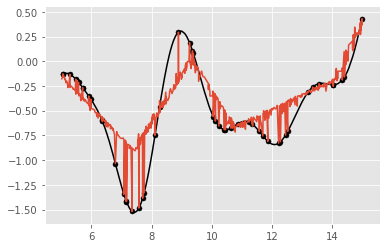

Epoch 22 batch 0 train Loss -0.2831 test Loss 4.6731 with MSE metric 1.2521


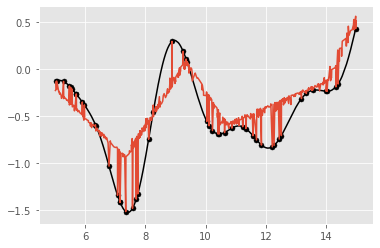

Epoch 23 batch 0 train Loss -0.2618 test Loss 3.8909 with MSE metric 1.0788


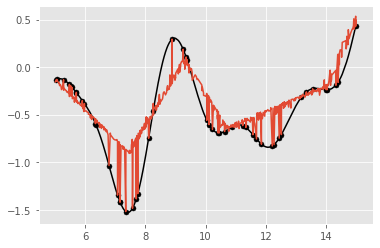

Epoch 24 batch 0 train Loss -0.2749 test Loss 5.7488 with MSE metric 1.4590


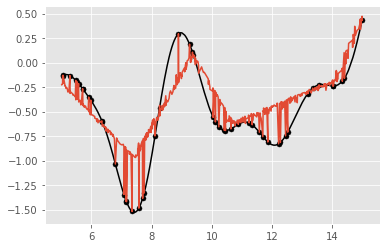

Epoch 25 batch 0 train Loss -0.3006 test Loss 5.7143 with MSE metric 1.3992


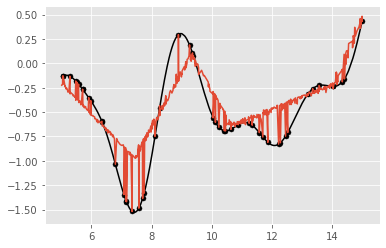

Epoch 26 batch 0 train Loss -0.3158 test Loss 7.5814 with MSE metric 1.6631


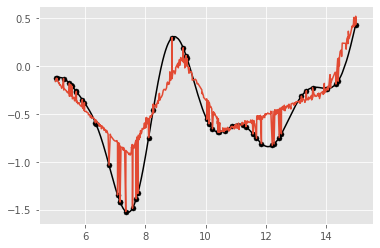

Epoch 27 batch 0 train Loss -0.3137 test Loss 7.3135 with MSE metric 1.5963


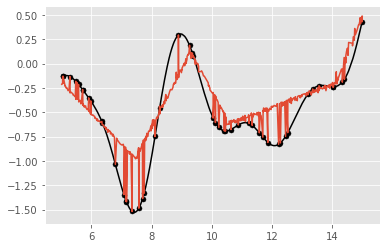

Epoch 28 batch 0 train Loss -0.3147 test Loss 6.7060 with MSE metric 1.5613


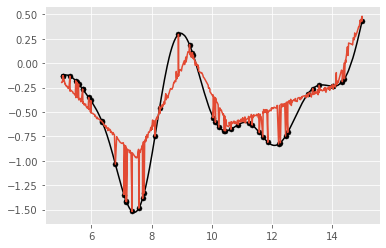

Epoch 29 batch 0 train Loss -0.3275 test Loss 6.7351 with MSE metric 1.4808


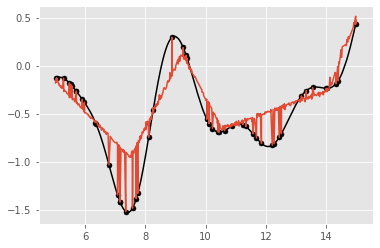

Epoch 30 batch 0 train Loss -0.3326 test Loss 7.4949 with MSE metric 1.5333


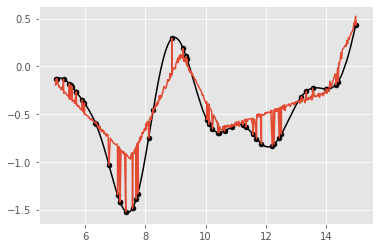

Epoch 31 batch 0 train Loss -0.3434 test Loss 6.5805 with MSE metric 1.3084


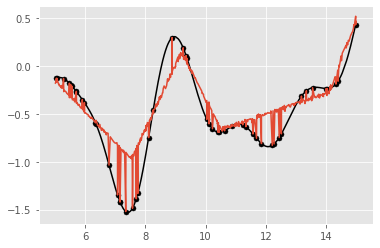

Epoch 32 batch 0 train Loss -0.3455 test Loss 8.9079 with MSE metric 1.7029


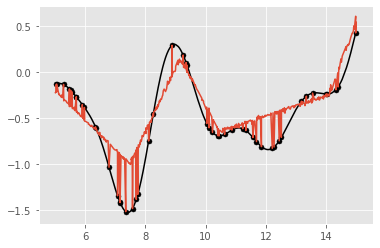

Epoch 33 batch 0 train Loss -0.3522 test Loss 7.0370 with MSE metric 1.3311


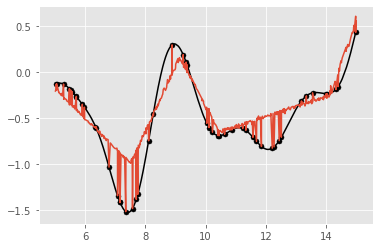

Epoch 34 batch 0 train Loss -0.3523 test Loss 6.8203 with MSE metric 1.3318


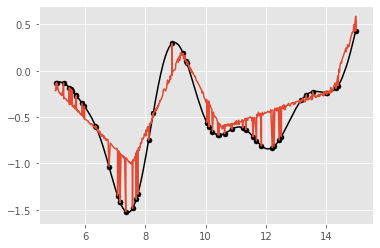

Epoch 35 batch 0 train Loss -0.3577 test Loss 8.5391 with MSE metric 1.5958


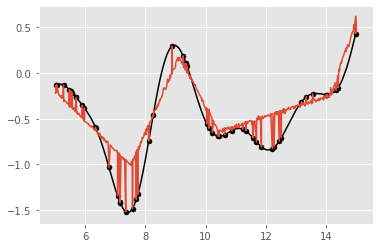

Epoch 36 batch 0 train Loss -0.3634 test Loss 9.0634 with MSE metric 1.5962


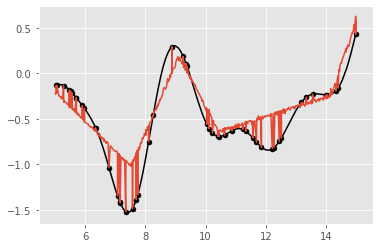

Epoch 37 batch 0 train Loss -0.3673 test Loss 8.4630 with MSE metric 1.5203


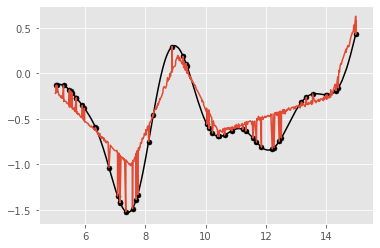

Epoch 38 batch 0 train Loss -0.3676 test Loss 7.8980 with MSE metric 1.3986


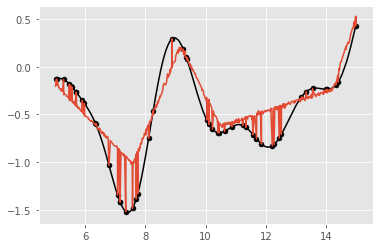

Epoch 39 batch 0 train Loss -0.3701 test Loss 8.9907 with MSE metric 1.5959


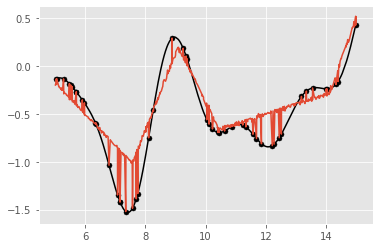

Epoch 40 batch 0 train Loss -0.3698 test Loss 7.4739 with MSE metric 1.3538


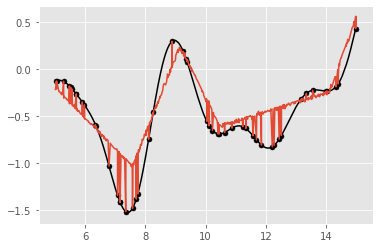

Epoch 41 batch 0 train Loss -0.3748 test Loss 8.2868 with MSE metric 1.4552


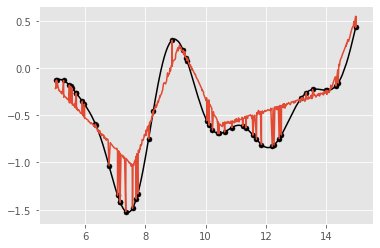

Epoch 42 batch 0 train Loss -0.3769 test Loss 8.7240 with MSE metric 1.5066


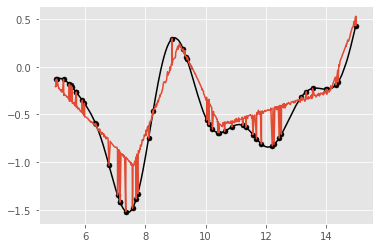

Epoch 43 batch 0 train Loss -0.3784 test Loss 9.2068 with MSE metric 1.5830


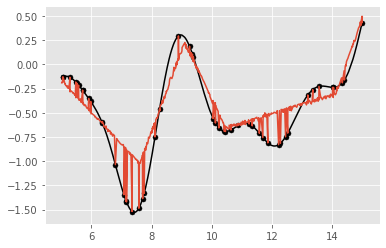

Epoch 44 batch 0 train Loss -0.3798 test Loss 9.0955 with MSE metric 1.5255


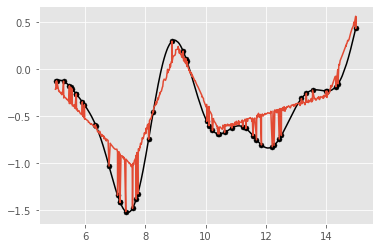

Epoch 45 batch 0 train Loss -0.3809 test Loss 10.6876 with MSE metric 1.8044


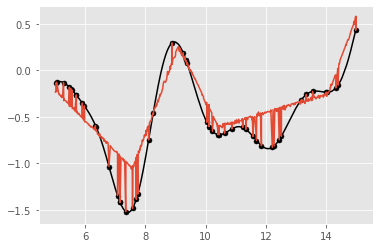

Epoch 46 batch 0 train Loss -0.3832 test Loss 8.2638 with MSE metric 1.3970


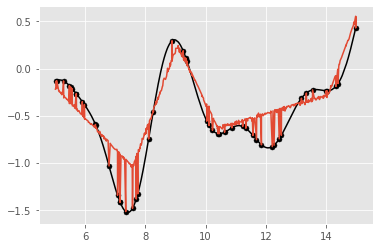

Epoch 47 batch 0 train Loss -0.3855 test Loss 10.6016 with MSE metric 1.7622


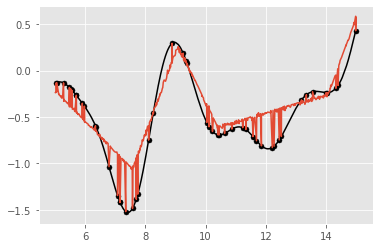

Epoch 48 batch 0 train Loss -0.3868 test Loss 9.7041 with MSE metric 1.5822


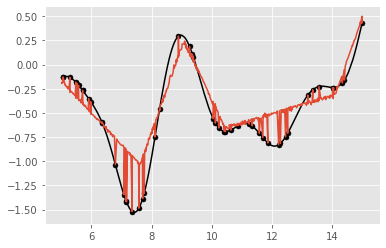

Epoch 49 batch 0 train Loss -0.3850 test Loss 8.6549 with MSE metric 1.4406


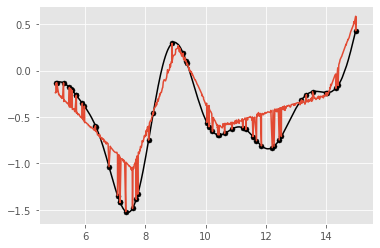

Epoch 50 batch 0 train Loss -0.3890 test Loss 10.1854 with MSE metric 1.6427


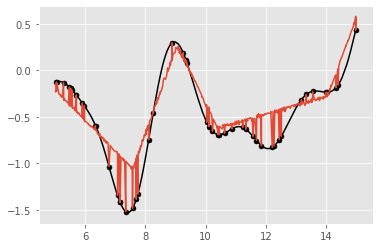

Epoch 51 batch 0 train Loss -0.3919 test Loss 9.2797 with MSE metric 1.4844


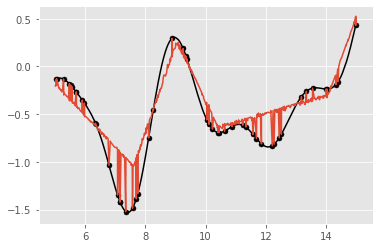

Epoch 52 batch 0 train Loss -0.3857 test Loss 9.3159 with MSE metric 1.5487


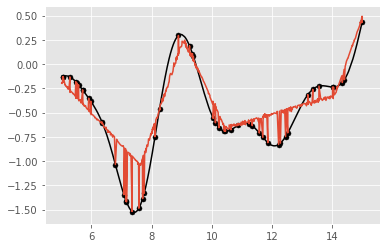

Epoch 53 batch 0 train Loss -0.3937 test Loss 9.9751 with MSE metric 1.6116


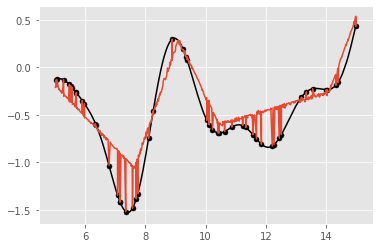

Epoch 54 batch 0 train Loss -0.3906 test Loss 8.4704 with MSE metric 1.4105


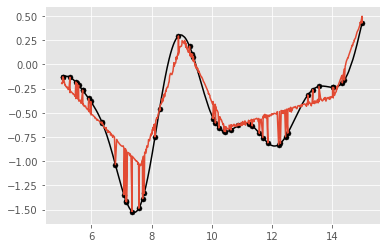

Epoch 55 batch 0 train Loss -0.3947 test Loss 10.7729 with MSE metric 1.7043


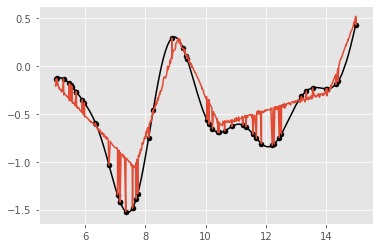

Epoch 56 batch 0 train Loss -0.3923 test Loss 10.0723 with MSE metric 1.6304


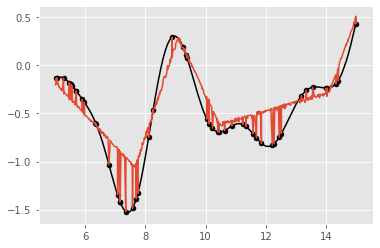

Epoch 57 batch 0 train Loss -0.3926 test Loss 10.6685 with MSE metric 1.7247


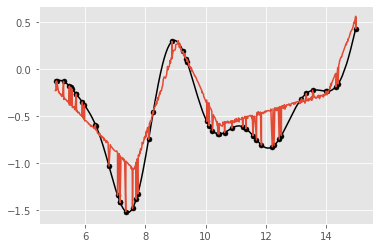

Epoch 58 batch 0 train Loss -0.3956 test Loss 9.0604 with MSE metric 1.4599


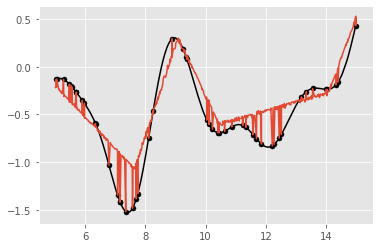

Epoch 59 batch 0 train Loss -0.3968 test Loss 10.0024 with MSE metric 1.6015


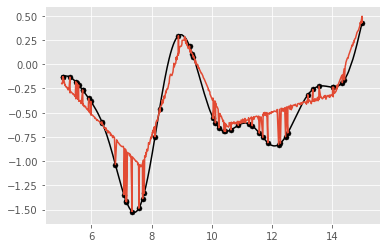

Epoch 60 batch 0 train Loss -0.4004 test Loss 8.0562 with MSE metric 1.2836


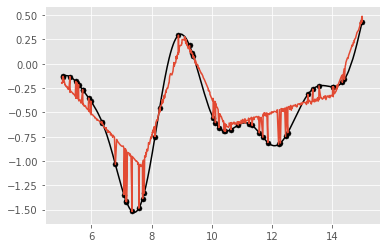

Epoch 61 batch 0 train Loss -0.4013 test Loss 8.6909 with MSE metric 1.3561


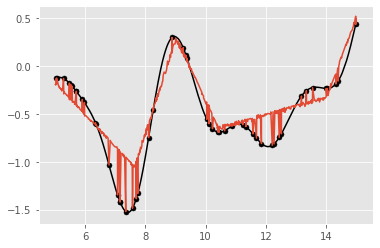

Epoch 62 batch 0 train Loss -0.3952 test Loss 8.5190 with MSE metric 1.3757


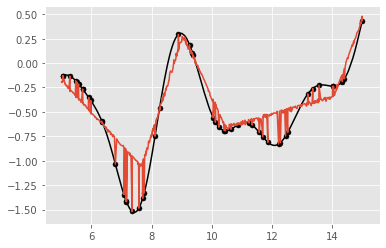

Epoch 63 batch 0 train Loss -0.4035 test Loss 9.1071 with MSE metric 1.3931


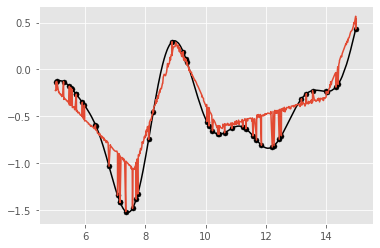

Epoch 64 batch 0 train Loss -0.4032 test Loss 10.3971 with MSE metric 1.6158


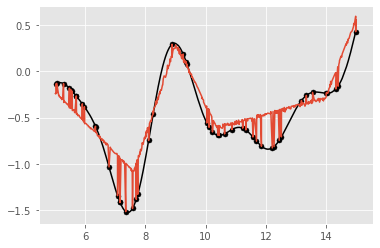

Epoch 65 batch 0 train Loss -0.4017 test Loss 11.1358 with MSE metric 1.7071


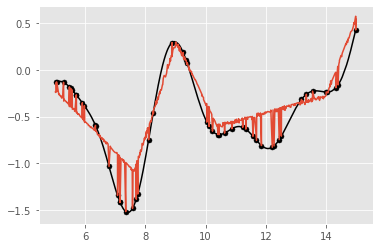

Epoch 66 batch 0 train Loss -0.4023 test Loss 10.4860 with MSE metric 1.6128


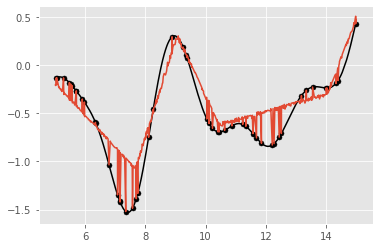

Epoch 67 batch 0 train Loss -0.4013 test Loss 10.4701 with MSE metric 1.6283


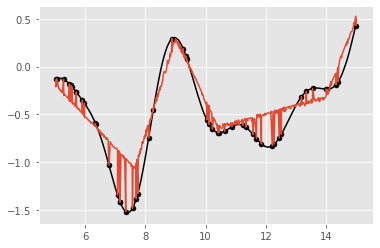

Epoch 68 batch 0 train Loss -0.3991 test Loss 8.5697 with MSE metric 1.3573


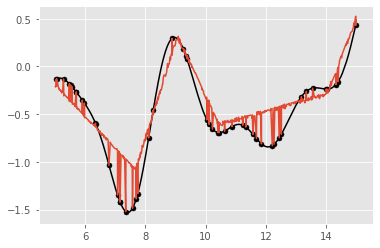

Epoch 69 batch 0 train Loss -0.4021 test Loss 8.4739 with MSE metric 1.3402


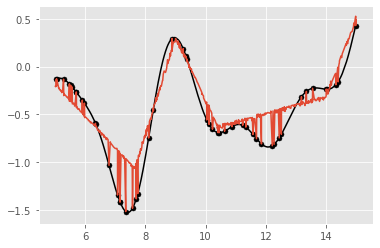

Epoch 70 batch 0 train Loss -0.3992 test Loss 8.7451 with MSE metric 1.3844


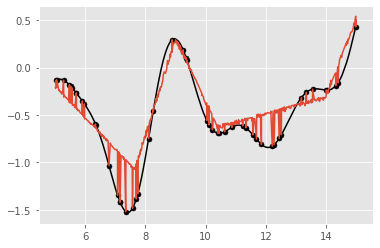

Epoch 71 batch 0 train Loss -0.4025 test Loss 10.2415 with MSE metric 1.6109


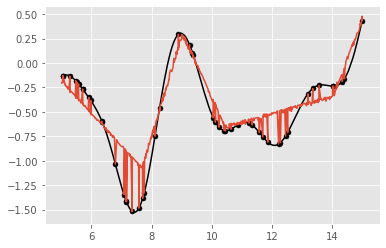

Epoch 72 batch 0 train Loss -0.4126 test Loss 8.0319 with MSE metric 1.2361


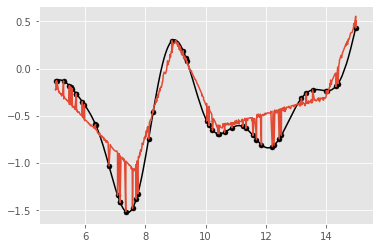

Epoch 73 batch 0 train Loss -0.4091 test Loss 8.7365 with MSE metric 1.3532


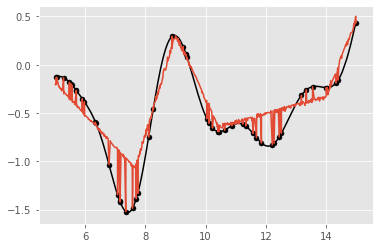

Epoch 74 batch 0 train Loss -0.4027 test Loss 10.8456 with MSE metric 1.6680


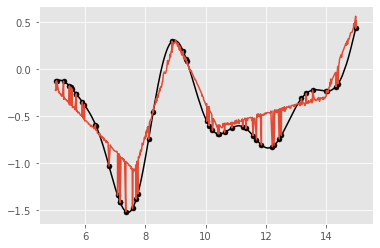

Epoch 75 batch 0 train Loss -0.4080 test Loss 8.7167 with MSE metric 1.3363


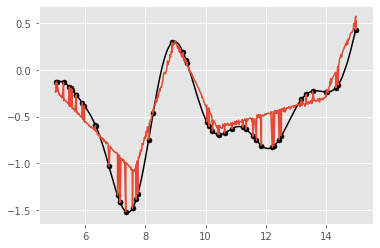

Epoch 76 batch 0 train Loss -0.4097 test Loss 10.4781 with MSE metric 1.5557


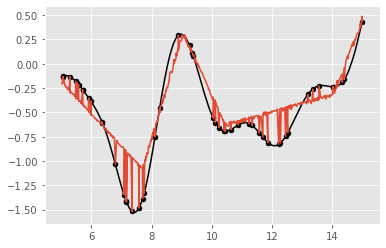

Epoch 77 batch 0 train Loss -0.4083 test Loss 10.1317 with MSE metric 1.5374


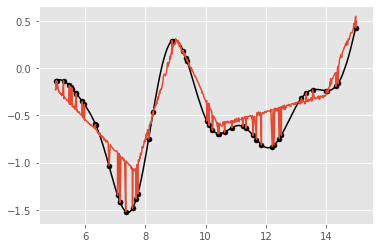

Epoch 78 batch 0 train Loss -0.4087 test Loss 9.3483 with MSE metric 1.4453


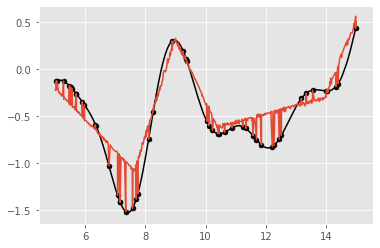

Epoch 79 batch 0 train Loss -0.4091 test Loss 10.0645 with MSE metric 1.5240


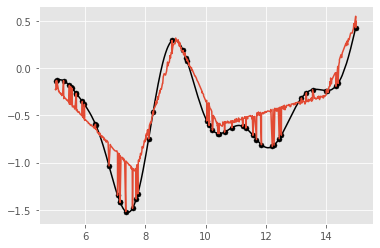

Epoch 80 batch 0 train Loss -0.4090 test Loss 11.3679 with MSE metric 1.7220


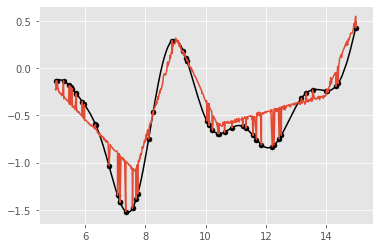

Epoch 81 batch 0 train Loss -0.4094 test Loss 11.4212 with MSE metric 1.7381


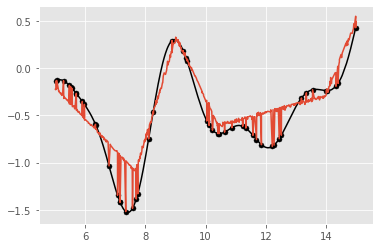

Epoch 82 batch 0 train Loss -0.4099 test Loss 9.9499 with MSE metric 1.5293


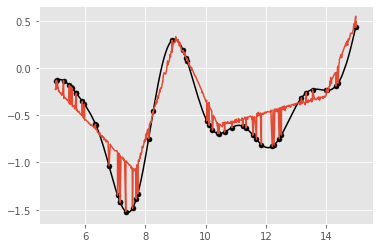

Epoch 83 batch 0 train Loss -0.4127 test Loss 9.7543 with MSE metric 1.4897


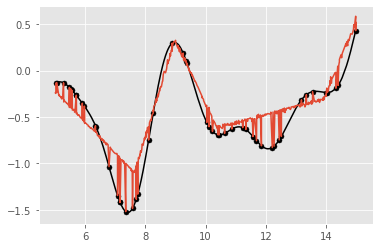

Epoch 84 batch 0 train Loss -0.4128 test Loss 9.0215 with MSE metric 1.3345


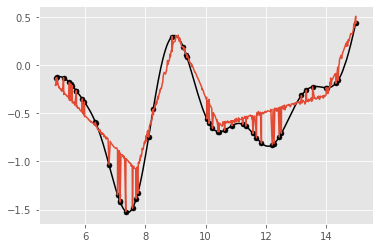

Epoch 85 batch 0 train Loss -0.4092 test Loss 9.4923 with MSE metric 1.4442


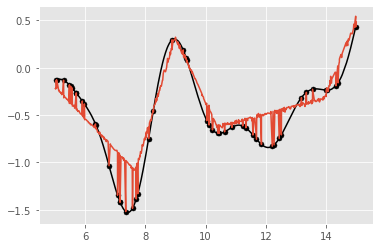

Epoch 86 batch 0 train Loss -0.4134 test Loss 9.0520 with MSE metric 1.3836


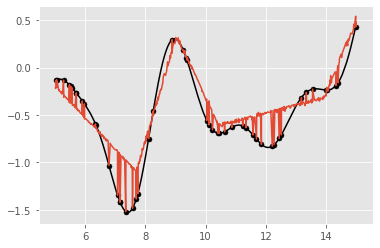

Epoch 87 batch 0 train Loss -0.4107 test Loss 11.3641 with MSE metric 1.6855


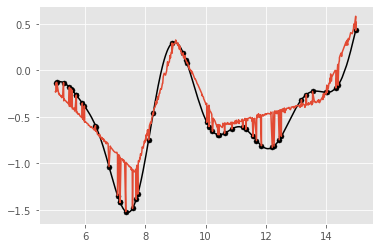

Epoch 88 batch 0 train Loss -0.4118 test Loss 11.8484 with MSE metric 1.7639


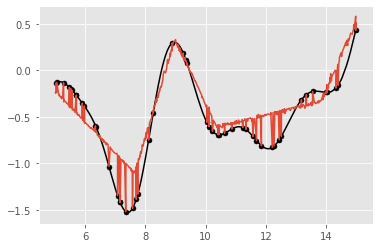

Epoch 89 batch 0 train Loss -0.4157 test Loss 9.4198 with MSE metric 1.3772


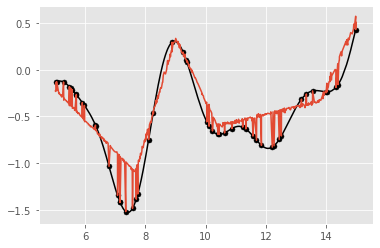

Epoch 90 batch 0 train Loss -0.4127 test Loss 10.0335 with MSE metric 1.4995


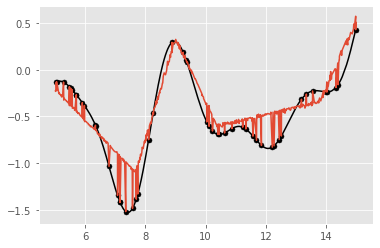

Epoch 91 batch 0 train Loss -0.4144 test Loss 11.1046 with MSE metric 1.6406


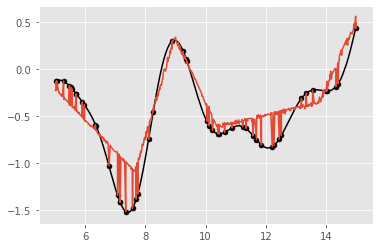

Epoch 92 batch 0 train Loss -0.4152 test Loss 10.6930 with MSE metric 1.5770


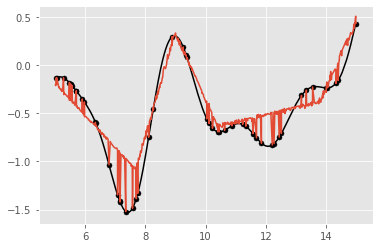

Epoch 93 batch 0 train Loss -0.4126 test Loss 11.6865 with MSE metric 1.7286


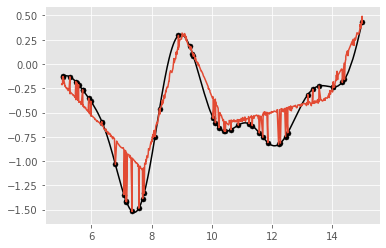

Epoch 94 batch 0 train Loss -0.4131 test Loss 8.8312 with MSE metric 1.3387


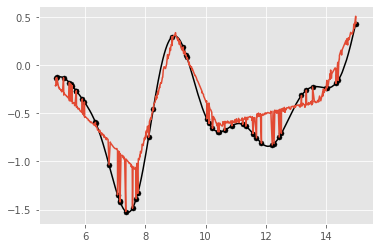

Epoch 95 batch 0 train Loss -0.4138 test Loss 8.3726 with MSE metric 1.2714


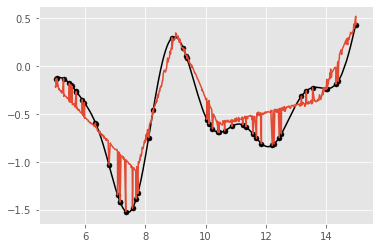

Epoch 96 batch 0 train Loss -0.4186 test Loss 8.0772 with MSE metric 1.2046


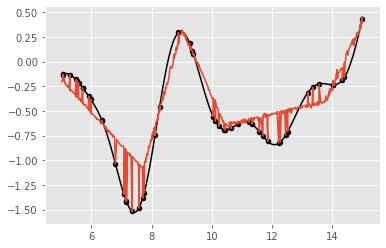

Epoch 97 batch 0 train Loss -0.4200 test Loss 11.9253 with MSE metric 1.7094


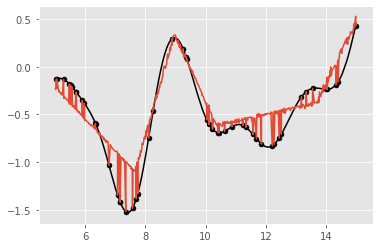

Epoch 98 batch 0 train Loss -0.4195 test Loss 9.5068 with MSE metric 1.3920


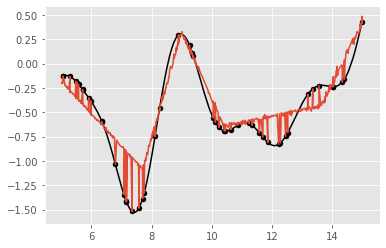

Epoch 99 batch 0 train Loss -0.4164 test Loss 10.8529 with MSE metric 1.5678


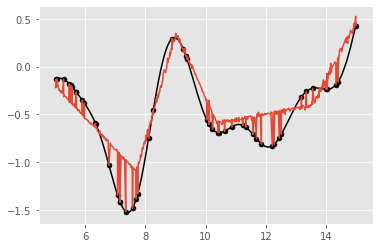

Epoch 100 batch 0 train Loss -0.4171 test Loss 9.2518 with MSE metric 1.3791


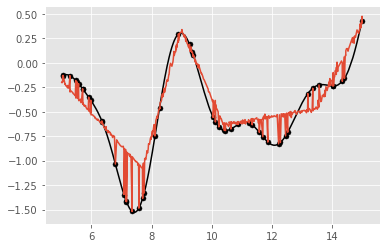

Epoch 101 batch 0 train Loss -0.4180 test Loss 10.4914 with MSE metric 1.5116


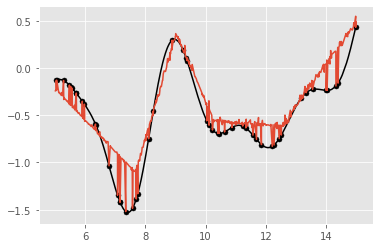

Epoch 102 batch 0 train Loss -0.4311 test Loss 10.1980 with MSE metric 1.4025


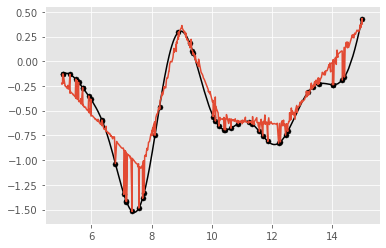

Epoch 103 batch 0 train Loss -0.4403 test Loss 9.6461 with MSE metric 1.3205


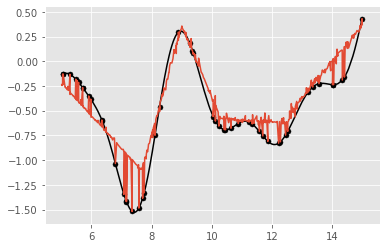

Epoch 104 batch 0 train Loss -0.4452 test Loss 10.7856 with MSE metric 1.3959


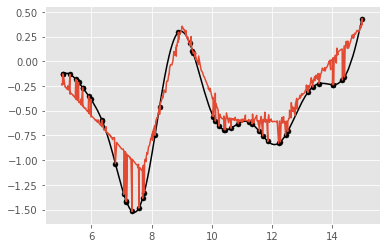

Epoch 105 batch 0 train Loss -0.4429 test Loss 10.4410 with MSE metric 1.3672


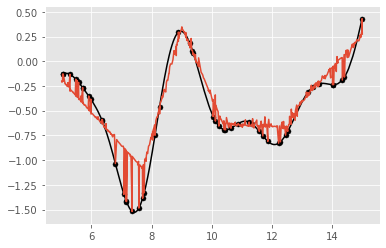

Epoch 106 batch 0 train Loss -0.4466 test Loss 10.9730 with MSE metric 1.4312


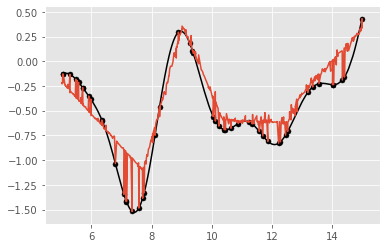

Epoch 107 batch 0 train Loss -0.4424 test Loss 8.9687 with MSE metric 1.2352


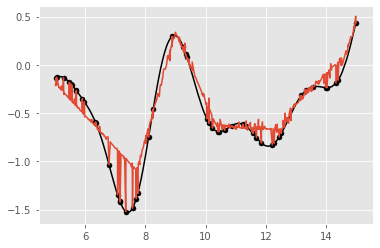

Epoch 108 batch 0 train Loss -0.4551 test Loss 11.0074 with MSE metric 1.3945


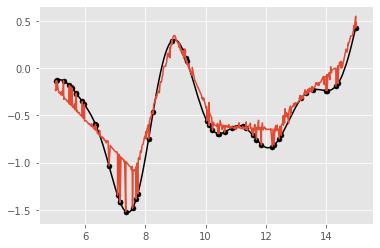

Epoch 109 batch 0 train Loss -0.4526 test Loss 13.0438 with MSE metric 1.6845


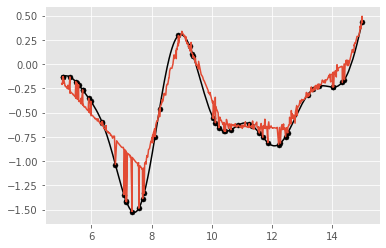

Epoch 110 batch 0 train Loss -0.4506 test Loss 9.5172 with MSE metric 1.2608


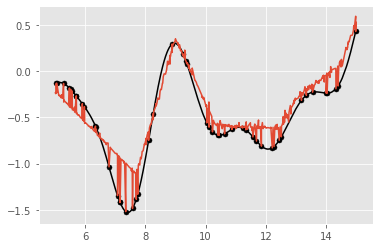

Epoch 111 batch 0 train Loss -0.4513 test Loss 13.1800 with MSE metric 1.6416


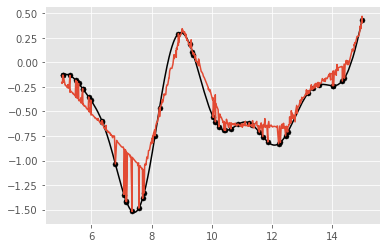

Epoch 112 batch 0 train Loss -0.4548 test Loss 12.2055 with MSE metric 1.5416


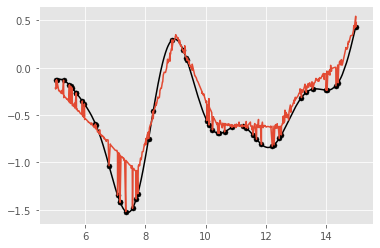

Epoch 113 batch 0 train Loss -0.4518 test Loss 10.5858 with MSE metric 1.3797


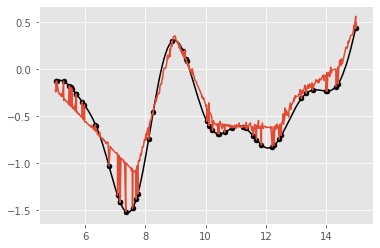

Epoch 114 batch 0 train Loss -0.4546 test Loss 10.9496 with MSE metric 1.3933


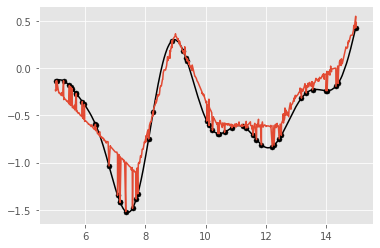

Epoch 115 batch 0 train Loss -0.4561 test Loss 10.2228 with MSE metric 1.3138


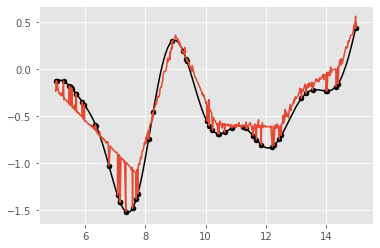

Epoch 116 batch 0 train Loss -0.4598 test Loss 12.9772 with MSE metric 1.6839


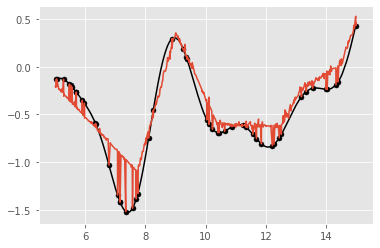

Epoch 117 batch 0 train Loss -0.4465 test Loss 10.8916 with MSE metric 1.4338


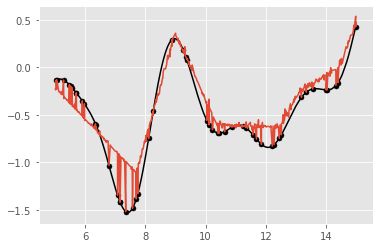

Epoch 118 batch 0 train Loss -0.4624 test Loss 12.7350 with MSE metric 1.5503


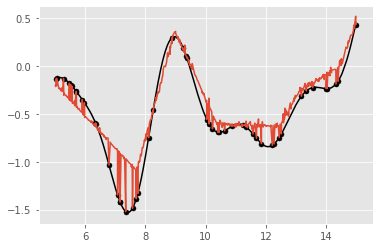

Epoch 119 batch 0 train Loss -0.4401 test Loss 9.8950 with MSE metric 1.2818


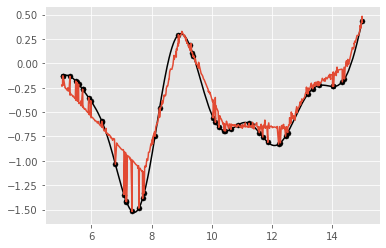

Epoch 120 batch 0 train Loss -0.4776 test Loss 10.9020 with MSE metric 1.3030


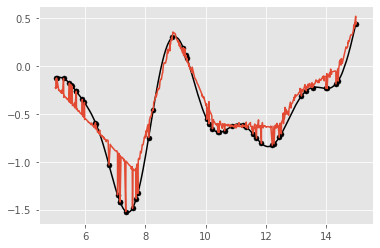

Epoch 121 batch 0 train Loss -0.4547 test Loss 11.0275 with MSE metric 1.4166


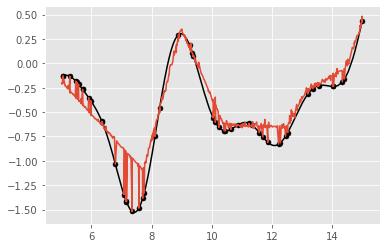

Epoch 122 batch 0 train Loss -0.4511 test Loss 12.6644 with MSE metric 1.6132


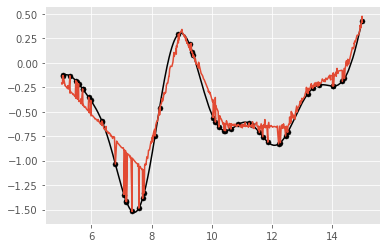

Epoch 123 batch 0 train Loss -0.4540 test Loss 11.2180 with MSE metric 1.4581


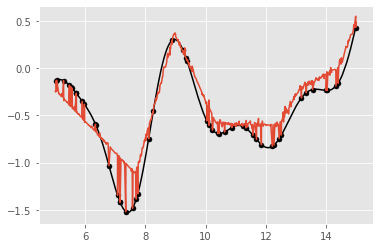

Epoch 124 batch 0 train Loss -0.4555 test Loss 13.0515 with MSE metric 1.6031


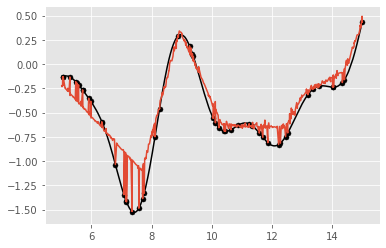

Epoch 125 batch 0 train Loss -0.4567 test Loss 14.0003 with MSE metric 1.7441


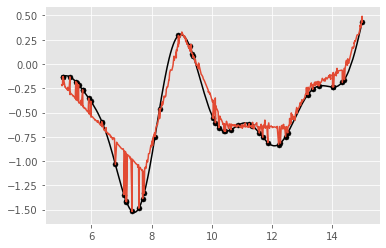

Epoch 126 batch 0 train Loss -0.4611 test Loss 13.0680 with MSE metric 1.6050


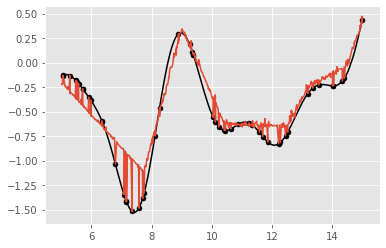

Epoch 127 batch 0 train Loss -0.4633 test Loss 11.6792 with MSE metric 1.4344


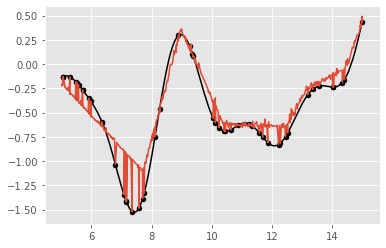

Epoch 128 batch 0 train Loss -0.4615 test Loss 11.7261 with MSE metric 1.4591


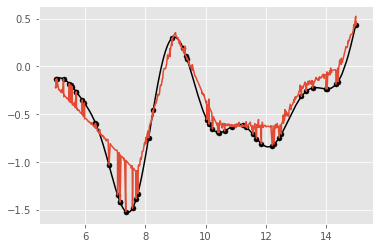

Epoch 129 batch 0 train Loss -0.4615 test Loss 12.9054 with MSE metric 1.5785


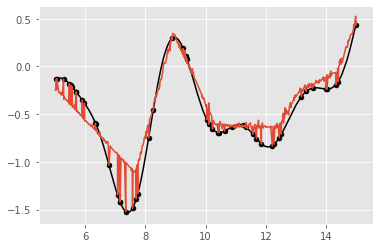

Epoch 130 batch 0 train Loss -0.4598 test Loss 12.9472 with MSE metric 1.5888


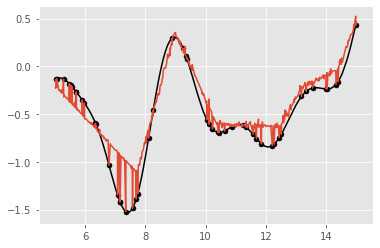

Epoch 131 batch 0 train Loss -0.4605 test Loss 12.8316 with MSE metric 1.5779


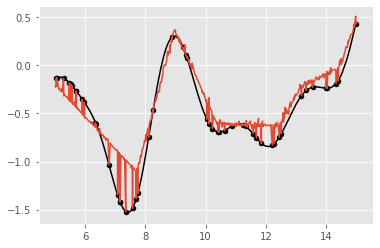

Epoch 132 batch 0 train Loss -0.4571 test Loss 9.7674 with MSE metric 1.2537


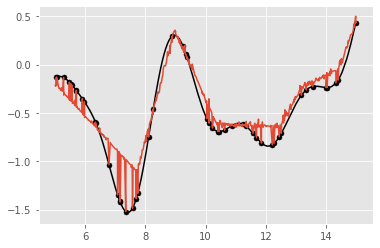

Epoch 133 batch 0 train Loss -0.4578 test Loss 12.1067 with MSE metric 1.5229


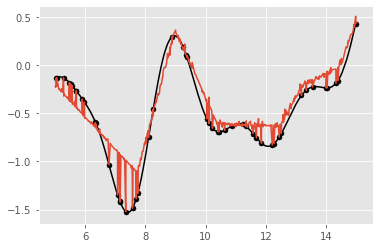

Epoch 134 batch 0 train Loss -0.4642 test Loss 10.1265 with MSE metric 1.2393


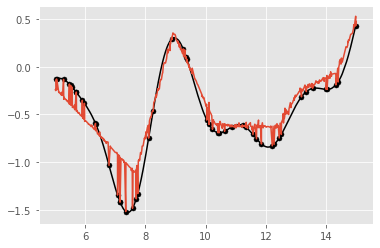

Epoch 135 batch 0 train Loss -0.4615 test Loss 9.8585 with MSE metric 1.2162


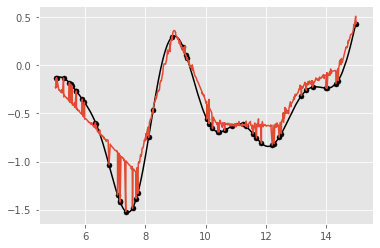

Epoch 136 batch 0 train Loss -0.4629 test Loss 13.0022 with MSE metric 1.6096


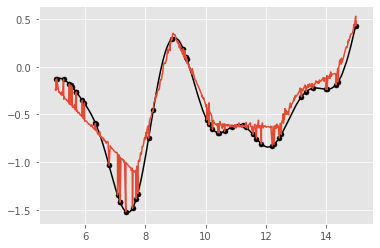

Epoch 137 batch 0 train Loss -0.4610 test Loss 13.9505 with MSE metric 1.7049


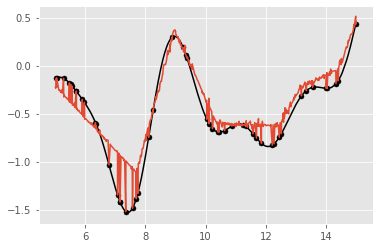

Epoch 138 batch 0 train Loss -0.4621 test Loss 12.8915 with MSE metric 1.5833


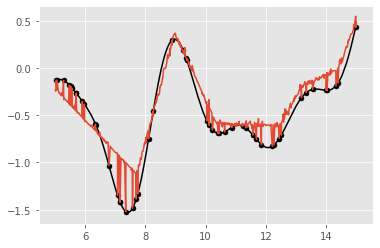

Epoch 139 batch 0 train Loss -0.4615 test Loss 11.7479 with MSE metric 1.4383


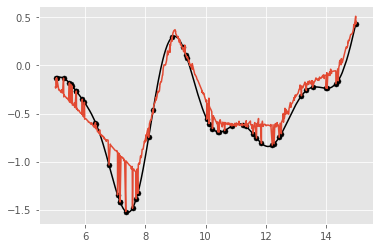

Epoch 140 batch 0 train Loss -0.4641 test Loss 11.3476 with MSE metric 1.3903


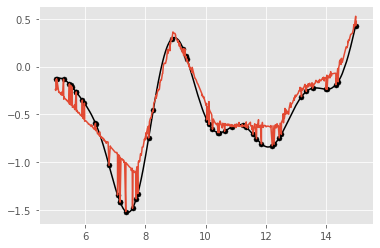

Epoch 141 batch 0 train Loss -0.4636 test Loss 12.1566 with MSE metric 1.4670


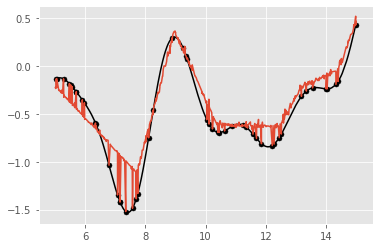

Epoch 142 batch 0 train Loss -0.4668 test Loss 11.6141 with MSE metric 1.3981


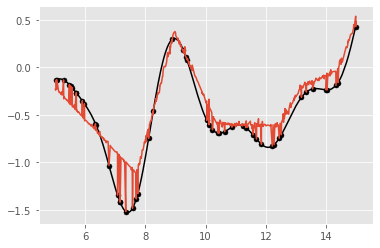

Epoch 143 batch 0 train Loss -0.4604 test Loss 12.3710 with MSE metric 1.5189


In [ ]:
if __name__ == '__main__':
#     batch_pos_tr, batch_tar_tr, _ = batch_creator.create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr, batch_s=1)
#     batch_pos_tr1 = batch_pos_tr[:, :-1]
#     batch_pos_tr_current = batch_pos_tr[:, 1:]
#     batch_pos_tr, batch_tar_tr, _ = batch_creator.fake_batch(pad_pos_tr, pad_y_fren_tr, batch_s=1)
#     batch_pos_tr1 = batch_pos_tr[:, :-1]
#     batch_pos_tr_current = batch_pos_tr[:, 1:]
    writer = tf.summary.create_file_writer(save_dir + '/logs/')
    optimizer_c = tf.keras.optimizers.RMSprop()
    decoder = classic_model.Decoder(32)
    EPOCHS = 50000
    batch_s  = 64
    run = 1; step = 0
#     num_batches = int(pad_y_fren_tr.shape[0] / batch_s)
    num_batches = 1500
    tf.random.set_seed(443)   
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer = optimizer_c, net = decoder)
    main_folder = "/Users/omernivron/Downloads/GPT/ckpt/check_"
    folder = main_folder + str(run); helpers.mkdir(folder)
    manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
    
    with writer.as_default():
        for epoch in range(EPOCHS):

            start = time.time()

            for batch_n in range(num_batches):
                m_tr.reset_states(); train_loss.reset_states()
                m_te.reset_states(); test_loss.reset_states()
#                 batch_pos_tr, batch_tar_tr, _ = batch_creator.create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr, batch_s=64)
#                 batch_pos_tr1 = batch_pos_tr[:, :-1]
#                 batch_pos_tr_current = batch_pos_tr[:, 1:]
                # batch_tar_tr shape := 128 X 59 = (batch_size, max_seq_len)
                # batch_pos_tr shape := 128 X 59 = (batch_size, max_seq_len)
#                 batch_pos_mask = masks.position_mask(batch_pos_tr)
#                 print(batch_pos_mask.shape)
#                 print(batch_pos_mask)
                pred, pred_log = train_step(decoder, optimizer_c, train_loss, m_tr, batch_pos_tr1, batch_pos_tr_current, batch_tar_tr)
                
                if batch_n % 1500 == 0:
#                 if epoch % 150 == 0:
                    real_x = batch_pos_tr_current[1, :]
                    real_y = batch_tar_tr[1, 1:]
                    samples = np.zeros((1, 599))
                    samples[0, :49] = batch_tar_tr[1, 1:50]
                    samples[0, 49:] = pred[1, 49:]
                    sorted_arr = np.argsort(real_x)
                    plt.plot(real_x[sorted_arr], real_y[sorted_arr], 'black')
                    plt.scatter(real_x[:50], real_y[:50], c = 'black', marker = "o", zorder = 1, s= 25)
                    plt.plot(real_x[sorted_arr], samples[0, sorted_arr])
                    plt.show()

                    batch_pos_te, batch_tar_te, _ = batch_creator.create_batch_gp_mim_2(pad_pos_te, pad_y_fren_te, batch_s=64)
                    batch_pos_te1 = batch_pos_te[:, :-1]
                    batch_pos_te_current = batch_pos_te[:, 1:]
                    pred_te, pred_log_te = test_step(decoder, test_loss, m_te, batch_pos_te1, batch_pos_te_current, batch_tar_te)
                    helpers.print_progress(epoch, batch_n, train_loss.result(), test_loss.result(), m_te.result())
                    helpers.tf_summaries(run, step, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result())
                    manager.save()
                step += 1
                ckpt.step.assign_add(1)

#             print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

In [ ]:
plt.plot(samples[0, sorted_arr])

In [ ]:
real_x[sorted_arr]

In [ ]:
batch_pos_tr_current.shape

In [ ]:
pred[1, :]

In [ ]:
batch_tar_tr[1, 2]

In [ ]:
sorted_arr

In [ ]:
samples[0, :50] = batch_tar_tr[1, :50]

In [ ]:
sorted_arr = np.argsort(real_x[:50])
plt.plot(real_x[:50][sorted_arr], samples[0, :50][sorted_arr])

In [ ]:
real_x = batch_pos_tr_current[1, :]
real_y = batch_tar_tr[1, 1:]
samples = np.zeros((1, 599))
samples[0, :49] = batch_tar_tr[1, 1:50]
samples[0, 49:] = pred[1, 49:]
sorted_arr = np.argsort(real_x)
plt.plot(real_x[sorted_arr], real_y[sorted_arr], 'black')
plt.scatter(real_x[:50], real_y[:50], c = 'black', marker = "o", zorder = 1, s= 25)
plt.plot(real_x[sorted_arr], samples[0, sorted_arr])
plt.show()

In [ ]:
batch_pos_tr[1, 599]

In [ ]:
samples = np.zeros((50, 600))
for sample in range(50):
     _, _, samples[sample, :] = infer.inference(decoder, pos = batch_pos_tr[1, :600].reshape(1, -1), tar = batch_tar_tr[1, :50].reshape(1, -1), num_steps = 550)

samples[:, :50] = batch_tar_tr[1, :50]

In [ ]:
batch_tar_tr.shape

In [ ]:
batch_pos_tr[1, sorted_arr]

In [ ]:
plt.style.use( 'ggplot')
sorted_arr = np.argsort(batch_pos_tr[1, :])
for i in range(4, 5):
    plt.plot(batch_pos_tr[1, sorted_arr], samples[i, sorted_arr], 'lightsteelblue', alpha = 0.6, zorder = -1)
plt.plot(batch_pos_tr[1, sorted_arr], batch_tar_tr[1, sorted_arr], 'black')
plt.scatter(batch_pos_tr[1, :50], batch_tar_tr[1, :50], c = 'black', marker = "o", zorder = 1, s= 25)
plt.show()

In [ ]:
batch_pos_tr[1, sorted_arr]

In [ ]:
for i in range(batch_pos_tr.shape[0]):
    plt.plot(batch_pos_tr[i, :], batch_tar_tr[i, :])

In [ ]:
extrapo = True

In [ ]:
if extrapo:
    x = np.load('/Users/omernivron/Downloads/GPT_data_goldstandard/x_extra.npy')
    y = np.load('/Users/omernivron/Downloads/GPT_data_goldstandard/y_extra.npy')
else:
    x = np.load('/Users/omernivron/Downloads/GPT_data_goldstandard/x_interpol.npy')
    y = np.load('/Users/omernivron/Downloads/GPT_data_goldstandard/y_interpol.npy')

In [ ]:
mse_metric = 0; r_sq_metric = 0; kuee_metric = 0;
μ = []; σ = []
m = int(x.shape[0] / 10)
y_mean = np.mean(y[:m, :40])
y_te = y[:m, 40]
for j in range(0, m):
    x_tr = x[j, :41].reshape(1, -1)
    y_tr = y[j, :40].reshape(1, -1)
    μ_te = infer.inference(decoder, x_tr, y_tr)
#     μ_te, log_σ_te = infer.inference(decoder, x_tr, y_tr, mh=True)


    μ.append(μ_te[0][-1].numpy()); 
#     σ.append(log_σ_te[-1])
#     kuee_metric += metrics.KUEE(y_te[j], μ_te[-1], np.exp(log_σ_te[-1]))
#     if (j % 400 == 0): 
#         print('J: ', j)
#         axes = plt.gca()
#         axes.set_ylim([-2, 2])
#         plt.scatter(x_tr[:, :-1], y_tr, c = 'black')
#         plt.scatter(x_tr[:, 1:], μ_te, c='navy')
#         plt.scatter(x_tr[:, -1], y_te[j], c='purple')
#         plt.scatter(x_tr[:, -1], μ_te[-1], c='red')
# #         plt.errorbar(x = x_tr[:, 40], y = (μ_te[-1]), yerr = 2 * np.exp(log_σ_te[-1]), fmt='o', ecolor='g', capthick=2)


        
        
# #         plt.fill_between(x_tr[:, 1:].squeeze(), μ_te -2 * np.exp(log_σ_te), μ_te  + 2 * np.exp(log_σ_te), alpha=.2)

#         plt.show()
    
mse_metric = metrics.mse(y_te, μ) 
r_sq_metric = metrics.r_squared(y_te, μ, y_mean)  
mse_metric *= (1 / m)
# kuee_metric *= (1 / m)

In [ ]:
r_sq_metric

In [ ]:
    mse_metric

In [ ]:
t = tf.constant([[1, 1, 1]])
t1 = tf.constant([[2, 0, 0]])

In [ ]:
masks.create_look_ahead_mask(10)

In [ ]:
tf.linalg.band_part(tf.ones((5, 5)), -1, 0)

In [ ]:
tf.multiply(t, t1)

In [ ]:
tf.repeat((1,1), 21)

In [ ]:
tf.constant(tf.repeat(0, 9), shape=(1, 9))

In [ ]:
a = tf.repeat(tf.concat([tf.constant(tf.repeat(0, 10), shape=(1, 10)), tf.constant(tf.repeat(1, 21), shape=(1, 21))], axis = 1), 64, axis=0)

In [ ]:
a[30]

In [ ]:
tf.transpose